In [ ]:
import torch
import os

import numpy as np
import statistics

import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torchvision import transforms

from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.utils.data import ConcatDataset, DataLoader
import random

In [3]:
from preprocess import preprocess

In the final analysis, I decided to test what would be the accuracy for a binary classification (tumor vs. no tumor)?

It could be assumed that any samples presenting pathological changes in the tissues would be examined carefully by a doctor and some multiple tests would be run to confirm the diagnosis. Because of that, the focus of the final test was to correctly detect positive and negative samples and check the accuracy of the binary classification.

The model architecture remained the same as the one used for the best prediction, with a modified output layer for binary classification. And the dataset was the same as before with one change: all positive labels were converted into 1. 

New class weights were calculated, as the dataset consists of all together almost 3 times more positive samples than negative ones.

### Preprocessing

In [4]:
dataset = torch.load("dataset.pth")

In [5]:
images = dataset['images']
labels = dataset['labels']

In [6]:
for idx, label in enumerate(labels):
    if label != 0:
        labels[idx] = 1

In [7]:
weights = torch.zeros((2))

for idx,label in enumerate(weights):
    weights[idx] = 1 - list(labels).count(idx) / len(labels)

weights

tensor([0.7426, 0.2574])

In [8]:
new_dataset = {"images":images, "labels":labels}

In [9]:
trainloader,testloader,valloader = preprocess(dataset, 64)

In [10]:
images = []
labels = []

for img, lab in trainloader:
    images.append(img)
    labels.append(lab)

    images.append(torch.flip(img, dims=(2,)))
    labels.append(lab)

    images.append(torch.clamp(img * (1 + random.uniform(-0.3,0.3)), 0, 1) )
    labels.append(lab)


images_tensor = torch.cat(images, dim=0)
labels_tensor = torch.cat(labels, dim=0)

temp_dataset = torch.utils.data.TensorDataset(images_tensor, labels_tensor)

In [11]:
trainloader = torch.utils.data.DataLoader(temp_dataset, batch_size=64, shuffle=True)

In [12]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

In [13]:
def show_image(tensor_img):
    plt.imshow(tensor_img.squeeze(), cmap='gray')
    plt.show()

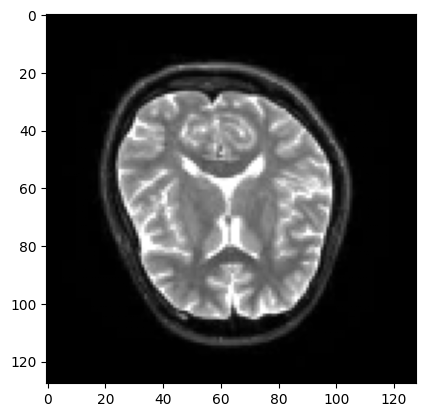

tensor(0)


In [14]:
sample_id = 0

show_image(images[sample_id])
print(labels[sample_id])

### Model

In [15]:
conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=2)
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(16, 64, 3)
conv3 = nn.Conv2d(64, 128, 7)
conv4 = nn.Conv2d(128, 256, 9)
fc1 = nn.Linear(256*2*2, 512)
fc3 = nn.Linear(512, 128)
fc4 = nn.Linear(128, 2)

x = images[sample_id].unsqueeze(0)
x = pool(F.relu(conv1(x)))
# # # x=F.relu(conv2(x))
x = pool(F.relu(conv2(x)))
x = pool(F.relu(conv3(x)))
x = pool(F.relu(conv4(x)))
# x = torch.flatten(x,1)
# # # x.shape
# x = F.relu(fc1(x))
# x = F.relu(fc3(x))
# x = fc4(x)
x.shape

torch.Size([1, 256, 2, 2])

In [16]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 =  nn.Conv2d(in_channels=1, out_channels=16, kernel_size=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 7)
        self.conv4 = nn.Conv2d(128, 256, 9)

        self.fc1 = nn.Linear(256*2*2, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

net = Net()

In [ ]:
device = torch.device(os.getenv("DEVICE"))
net.to(device)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(9, 9), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=2, bias=True)
)

### Training

In [18]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [19]:
train_loss_plot = []
test_loss_plot = []

In [20]:
best_result = np.inf
test_loss_array = []
n_epochs = 15
patience = 3

for epoch in range(n_epochs):

    total_loss = 0
    for X_batch, y_batch in trainloader:

        X_batch = X_batch.to(device,dtype=torch.float32)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        outputs = net(X_batch)

        loss = criterion(outputs.to(device), y_batch)
        train_loss_plot.append(loss.item())

        loss.backward()
        optimizer.step()

        total_loss += loss.item() 

    test_loss = 0
    with torch.no_grad():  
            
            for X_batch, y_batch in testloader:

                X_batch = X_batch.to(device,dtype=torch.float32)
                y_batch = y_batch.to(device)

                outputs = net(X_batch)
                t_loss = criterion(outputs.to(device), y_batch)
                test_loss_plot.append(t_loss.item())

                test_loss+=t_loss

    loss = total_loss / (len(trainloader))
    loss_test = test_loss / (len(testloader))

    test_loss_array.append(loss_test)

    if loss_test < best_result:
        torch.save(net.state_dict(), "./custom_net_aug_binary.pth")

    print(f"Epoch: {epoch}, Train loss: {loss}, Test loss: {loss_test}")

    if len(test_loss_array)>patience+1:
        if not (any(x > (test_loss_array[-1]+0.001) for x in test_loss_array[len(test_loss_array)-patience-1:-1])):
            break

Epoch: 0, Train loss: 0.652047713493046, Test loss: 0.4237869381904602
Epoch: 1, Train loss: 0.33264933008896674, Test loss: 0.1752122938632965
Epoch: 2, Train loss: 0.1810862813537058, Test loss: 0.161834254860878
Epoch: 3, Train loss: 0.12548507591219324, Test loss: 0.10245618969202042
Epoch: 4, Train loss: 0.07695122671460634, Test loss: 0.09073781222105026
Epoch: 5, Train loss: 0.049287496686692495, Test loss: 0.10947120934724808
Epoch: 6, Train loss: 0.0384775058403121, Test loss: 0.06865224987268448
Epoch: 7, Train loss: 0.01800537788734992, Test loss: 0.123102568089962


At the end model started to overfit, but early stopping broke the training loop and the best model was used

<Axes: >

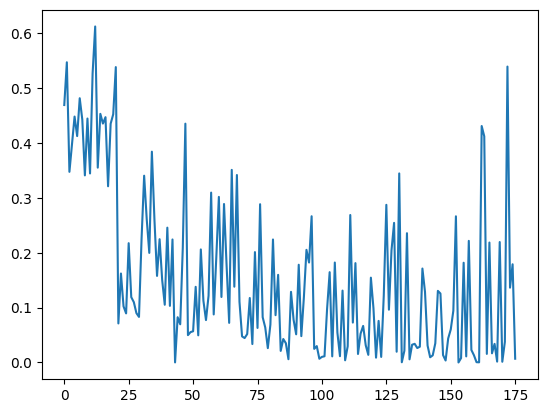

In [21]:
import seaborn as sns

sns.lineplot(data = test_loss_plot)

<Axes: >

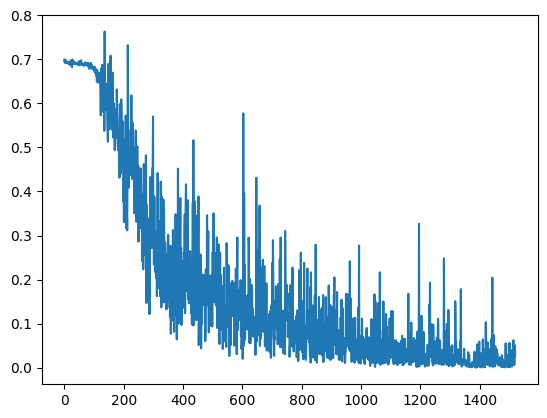

In [22]:
sns.lineplot(data = train_loss_plot)

In [23]:
net.load_state_dict(torch.load("custom_net_aug_binary.pth"))

<All keys matched successfully>

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [25]:
accuracy = []
f1_scr = []
precision = []
recall=[]

with torch.no_grad():
    
    for X_batch, y_batch in valloader:
        outputs_pred = net(X_batch.to(device))

        _, topi = outputs_pred.topk(1)

        topi=topi.cpu()

        acc = accuracy_score(y_batch,topi.squeeze(-1))
        f1 = f1_score(y_batch,topi.squeeze(-1), average="macro")
        pr = precision_score(y_batch,topi.squeeze(-1), average="macro")
        rec = recall_score(y_batch,topi.squeeze(-1),average="macro")


        accuracy.append(float(acc))
        f1_scr.append(float(f1))
        precision.append(float(pr))
        recall.append(float(rec))


### Results

In [27]:
print(statistics.mean(accuracy))
print(statistics.mean(f1_scr))
print(statistics.mean(precision))
print(statistics.mean(recall))

0.9829545454545454
0.973388928384324
0.9779163857572384
0.9709034727412511


And in the end the final result of 98% was achieved for binary clasification - tumor / no tumor. 